# Planning a surf trip using IOOS EDS Model Viewer

Created: 2022-11-25

Updated: 2022-12-07

Author: [Mathew Biddle](mailto:mathew.biddle@noaa.gov)

**Resources:**
* EDS IOOS Model Viewer: https://eds.ioos.us/
* EDS IOOS Model Viewer Map: https://eds.ioos.us/map/
* EDS THREDDS Catalog: https://eds.ioos.us/thredds/catalog/catalog.html

Process:
1. Look at significant wave height forecast for MD coast (38.2101 °N 75.0867 °W). Look for significant wave heights >1m or some significant increase to narrow down the investigation. This will get you to a 12-24 hour window typically.
   * Resources in EDS include:
     * Wave Watch III (WW3) WW3 Wave Hgt @ NOAA WW3 Wave Height https://edsdata.oceansmap.com/thredds/catalog/EDS/NOGAPS/catalog.html
     * GFS-Wave WW3 Atlantic Height @ NOAA GFS-Wave Atlantic Wave Height https://eds.ioos.us/thredds/catalog/ioos/gfswave/global/catalog.html
     * The Nearshore Wave Prediction System (NWPS) Chesapeake NWPS AKQ Wave Hgt @ NOAA NWPS Chesapeake Wave Height - https://eds.ioos.us/thredds/catalog/ioos/nwps/akq/catalog.html
     * Best GFS Wave Atlantic Ocean 16km Time Series - https://eds.ioos.us/thredds/dodsC/ioos/gfswave/atlocn/Best, https://eds.ioos.us/thredds/catalog/ioos/gfswave/atlocn/catalog.html?dataset=ioos/gfswave/atlocn/Best
1. Once you find a blip in wave heights, take a look at wave periods in that time period to see if it's just a storm or a decent offshore swell. Typically periods >5 seconds is a good start. That should get you down to a 12 hour window where it might be decent to surf.
1. Next look at the forecasted wave direction and wind direction/speed. Lots of nuances in these two pieces as wind direction could be bad (onshore) but if speeds are low it could be alright. If wind direction good (offshore) but winds are strong, could be tricky. wave direction informs which spots would catch the swell. Not many features on MD coast (barrier island), so direction not as important. This should get you to a 6 hour'ish window.
1. Finally, look at tides and water temp (wetsuit or trunks?), sunrise, sunset times.
1. Run this process every hour leading up to the event - forecast will get more accurate the closer to the event. I will start looking at real-time buoy obs ~12 hours before the event.

# Set up coordinates for forecast

In [1]:
lat = 38.2101
lon = -75.0867 

lon360 = 360+lon # convert to degrees_east 0-360

print('lat: {}\nlon: {}\nlon360: {}'.format(lat,lon,lon360))

lat: 38.2101
lon: -75.0867
lon360: 284.9133


## Put coordinates on a map

Text(0.5, 1.0, 'lon:-75.0867 lat:38.2101')

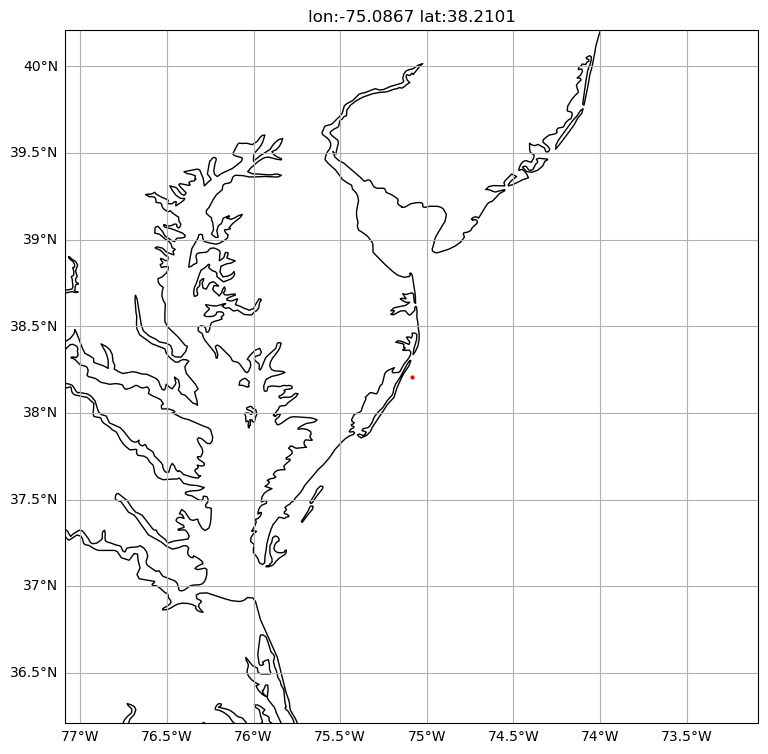

In [2]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.pyplot as plt

projection=ccrs.PlateCarree() 
figsize=(9, 9)

title='lon:{} lat:{}'.format(lon,lat)

fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection=projection))
gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.plot(lon, lat, markersize=2, marker='o', color='red')

ax.set_extent([lon-2, lon+2, lat-2, lat+2], ccrs.PlateCarree())

ax.coastlines("10m")

plt.title(title)

# GFS WW3

![image.png](gfs_surf_screenshot.png)

https://eds.ioos.us/thredds/catalog/ioos/gfswave/global/catalog.html

Just use xarray to open dataset directly.

In [ ]:
#import cf_xarray
import xarray as xr

In [ ]:
url = 'https://eds.ioos.us/thredds/dodsC/ioos/gfswave/global/Best'

ds = xr.open_dataset(url)

wvhgt_gfs = ds.filter_by_attrs(abbreviation='HTSGW').sel(lat=lat, lon=lon360, method="nearest")
#wvhgt_gfs = ds.Significant_height_of_combined_wind_waves_and_swell_surface.sel(lat=lat, lon=lon360, method="nearest")

wvhgt_gfs

In [ ]:
wvhgt_gfs.plot.scatter(x='time',y=list(wvhgt_gfs.data_vars)[0])

# NOAA WW3

In [ ]:
import datetime

today = datetime.datetime.now().strftime('%Y%m%d')

#url = 'http://edsdata.oceansmap.com/thredds/dodsC/EDS/NOGAPS/WW3_WAVE_HGT{}.nc'.format(today)

url = 'http://edsdata.oceansmap.com/thredds/dodsC/EDS/WW3_ATL_4M/WW3_ATL_4M_best.ncd'

ds = xr.open_dataset(url)

wvhgt_noaa = ds.filter_by_attrs(abbreviation='HTSGW').sel(lat=lat, lon=lon360, method="nearest")

wvhgt_noaa

Save data as data frame.

In [ ]:
df_noaa = wvhgt_noaa.to_dataframe()

In [ ]:
df_noaa.plot.scatter(x='time', y=list(wvhgt_noaa.data_vars)[0])

# Nearshore Wave Prediction System (NWPS) Chesapeake NWPS AKQ Wave Hgt

In [ ]:
url = 'https://eds.ioos.us/thredds/dodsC/ioos/nwps/akq/NWPS_AKQ-2022-11-28/LatLon_229X153-37p66N-75p76W'

ds = xr.open_dataset(url)

wvhgt_nwps = ds.filter_by_attrs(abbreviation='HTSGW').sel(lat=lat, lon=lon360, method="nearest")#

wvhgt_nwps

These data have 3 reference times for when the model was run. Shown below are the three different realizations for those model reference times. 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

for reftime in range(3):
    label = pd.to_datetime(wvhgt_nwps.isel(reftime=reftime)['reftime'].values).strftime('%Y-%m-%dT%H')
    wvhgt_nwps.to_array().isel(reftime=reftime).squeeze().plot.scatter(x="time", label=label)

plt.legend()

Let's pick the middle reference time as the realization we want to use.

In [ ]:
# Pick the middle reference time
wvhgt_nwps = wvhgt_nwps.isel(reftime=1).squeeze()

wvhgt_nwps

Now, let's plot those data.

In [ ]:
df_nwps = wvhgt_nwps.to_dataframe()

df_nwps.plot.scatter(x='time',y=list(wvhgt_nwps.data_vars)[0])

In [ ]:
wvhgt_nwps.plot.scatter(x='time', y=list(wvhgt_nwps.data_vars)[0])

print("Reference time {}".format(wvhgt_nwps['reftime'].values))

# Best GFS Wave Atlantic Ocean 16km

In [ ]:
url = 'https://eds.ioos.us/thredds/dodsC/ioos/gfswave/atlocn/Best'

ds = xr.open_dataset(url)

wvhgt_gfsatlocn = ds.filter_by_attrs(abbreviation='HTSGW').sel(lat=lat, lon=lon360, method="nearest")

wvhgt_gfsatlocn

In [ ]:
wvhgt_gfsatlocn.plot.scatter(x='time',y=list(wvhgt_gfsatlocn.data_vars)[0])

# Combine them all together in one plot

In [ ]:
import matplotlib.pyplot as plt

# initialize figure
fig, ax = plt.subplots(figsize=(10, 10))

# add scatter plots
wvhgt_gfs.plot.scatter(x='time', y=list(wvhgt_gfs.data_vars)[0], ax=ax, label='gfs')
wvhgt_noaa.plot.scatter(x='time', y=list(wvhgt_noaa.data_vars)[0], ax=ax, label='noaa ww3')
wvhgt_nwps.plot.scatter(x='time', y=list(wvhgt_nwps.data_vars)[0], ax=ax, label='nwps')
wvhgt_gfsatlocn.plot.scatter(x='time', y=list(wvhgt_gfsatlocn.data_vars)[0], ax=ax, label='gfsatlocn')

# add legend
ax.legend()

# set limits
ax.set_xlim(left = datetime.datetime.today()-datetime.timedelta(days=1) )

ax.set_ylabel('Significant height of combined wind waves and swell waves [m]')

# add a line for right now
ax.vlines(datetime.datetime.today(),ymin=0,ymax=2.5,color='grey')

In [ ]:
# try saving to array above, then combining all into one plot?

# Run all of it in one cell.

lat: 38.2101
lon: -75.0867
lon360: 284.9133
Getting data from https://eds.ioos.us/thredds/dodsC/ioos/gfswave/atlocn/Best
Getting data from https://eds.ioos.us/thredds/dodsC/ioos/nwps/akq/NWPS_AKQ-2022-11-28/LatLon_229X153-37p66N-75p76W
Getting data from http://edsdata.oceansmap.com/thredds/dodsC/EDS/WW3_ATL_4M/WW3_ATL_4M_best.ncd
Can't access data
Getting data from https://eds.ioos.us/thredds/dodsC/ioos/gfswave/global/Best
CPU times: total: 1.5 s
Wall time: 12min 12s


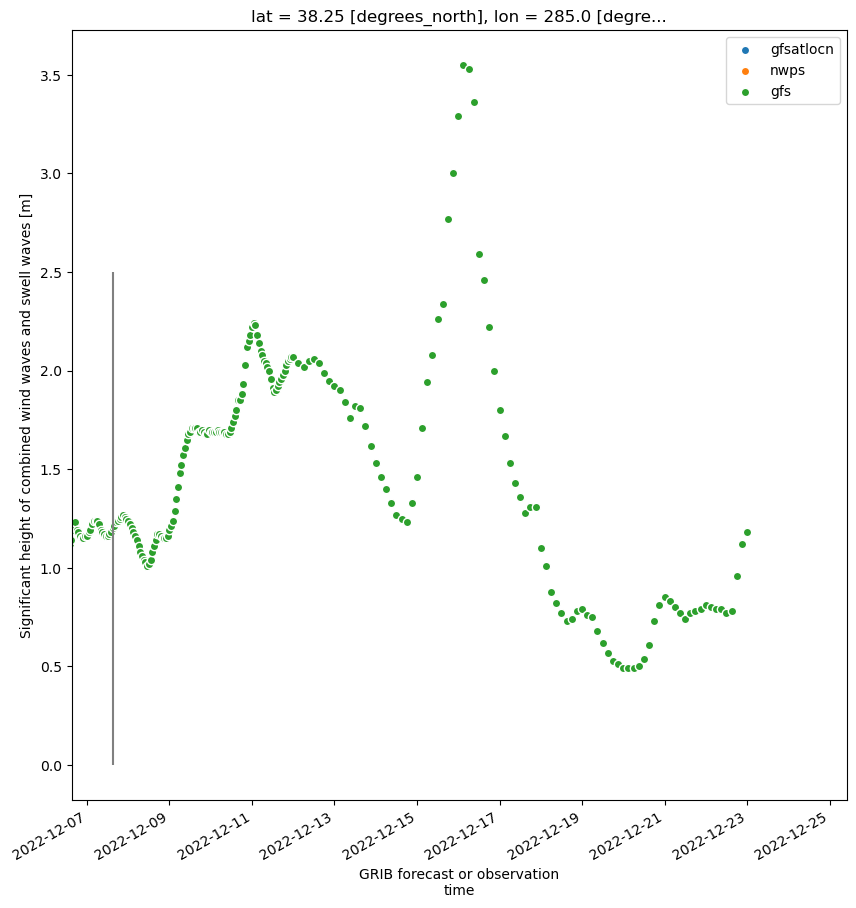

In [1]:
%%time

import matplotlib.pyplot as plt
import xarray as xr
import datetime

lat = 38.2101
lon = -75.0867 

lon360 = 360+lon # convert to degrees_east 0-360

print('lat: {}\nlon: {}\nlon360: {}'.format(lat,lon,lon360))

# initialize figure
fig, ax = plt.subplots(figsize=(10, 10))

urls = {'gfsatlocn': 'https://eds.ioos.us/thredds/dodsC/ioos/gfswave/atlocn/Best',
       'nwps': 'https://eds.ioos.us/thredds/dodsC/ioos/nwps/akq/NWPS_AKQ-2022-11-28/LatLon_229X153-37p66N-75p76W',
       'noaa': 'http://edsdata.oceansmap.com/thredds/dodsC/EDS/WW3_ATL_4M/WW3_ATL_4M_best.ncd',
       'gfs': 'https://eds.ioos.us/thredds/dodsC/ioos/gfswave/global/Best'}

for key in urls.keys():
    
    print('Getting data from {}'.format(urls[key]))
    
    ds = xr.open_dataset(urls[key])
    data = ds.filter_by_attrs(abbreviation='HTSGW').sel(lat=lat, lon=lon360, method="nearest")
    
    if key == 'nwps':
        data = data.isel(reftime=1).squeeze()
        
    try:
        data.plot.scatter(x='time', y=list(data.data_vars)[0], ax=ax, label=key)
    except:
        print("Can't access data")
        continue
    
# add legend
ax.legend()

# set limits
ax.set_xlim(left = datetime.datetime.today()-datetime.timedelta(days=1) )

ax.set_ylabel('Significant height of combined wind waves and swell waves [m]')

# add a line for right now
ax.vlines(datetime.datetime.today(),ymin=0,ymax=2.5,color='grey')